# __TelecomX - Parte 2: Modelos de prediccion__

## __Objetivo__

La empresa busca anticiparse al problema de cancelacion de clientes, por lo que vamos a construir un pipeline robusto para la etapa inicial del modelado cuyas tareas son lo siguiente:

- Preparar los datos (limpieza, codificacion y normalizacion).
- Realizar analisis de correlacion y seleccion de variables.
- Entrenar diferentes modelos de clasificacion, evaluar el rendimiento a traves de distintas metricas e interpretar los resultados de cada uno.
- Crear un reporte con algunas recomendaciones sobre los principales factores que influyen en la cancelacion de clientes.

## __Importar Librerias__

In [45]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
#import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

In [ ]:
# version de las libreria utilizadas
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'imblearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

numpy==2.2.6
pandas==2.3.1
matplotlib==3.10.3
seaborn==0.13.2
scikit-learn==1.6.1
imblearn==1.6.1
xgboost==3.0.5


: 

: 

: 

## __Importar datos__

In [ ]:
# cargar datos preprocesados desde GitHub
data = pd.read_csv('https://raw.githubusercontent.com/jbernalg/challenge_TelecomX/refs/heads/main/data_out/datos_tratados.csv', sep=',')
data.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,respaldo_online,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total,cuentas_diarias
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,Si,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30,0.242963
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,No,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40,0.221852
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,No,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85,0.615833
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,Si,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85,0.251282
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,No,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40,0.932222


: 

: 

: 

> Vamos a eliminar la variable _cuentas_diarias_ debido a que fue obtenida a partir de _cuenta_mensual_ por lo que no aporta informacion relevante.

In [ ]:
datos = data.drop(['cuentas_diarias'], axis=1)
datos.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,respaldo_online,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,Si,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,No,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,No,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,Si,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,No,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40


: 

: 

: 

In [ ]:
# resumen estadistico de las variables numericas
datos.describe()

,cancelacion,meses_contrato,cuenta_mensual,cuentas_total
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,32.421786,64.798208,2283.300441
std,0.441782,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,1.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


: 

: 

: 

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cancelacion              7032 non-null   int64  
 1   genero                   7032 non-null   object 
 2   jubilado                 7032 non-null   object 
 3   en_pareja                7032 non-null   object 
 4   dependientes             7032 non-null   object 
 5   meses_contrato           7032 non-null   int64  
 6   servicio_telefonico      7032 non-null   object 
 7   multiples_lineas         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_online         7032 non-null   object 
 10  respaldo_online          7032 non-null   object 
 11  proteccion_dispositivo   7032 non-null   object 
 12  soporte_efectivo         7032 non-null   object 
 13  streaming_TV             7032 non-null   object 
 14  streaming_peliculas     

: 

: 

: 

## __Encoding de variables categoricas__

In [ ]:
datos.columns

Index(['cancelacion', 'genero', 'jubilado', 'en_pareja', 'dependientes',
       'meses_contrato', 'servicio_telefonico', 'multiples_lineas',
       'servicio_internet', 'seguridad_online', 'respaldo_online',
       'proteccion_dispositivo', 'soporte_efectivo', 'streaming_TV',
       'streaming_peliculas', 'tipo_contrato', 'facturacion_electronica',
       'metodo_pago', 'cuenta_mensual', 'cuentas_total'],
      dtype='object')

: 

: 

: 

In [ ]:
# definir variables predictoras
X = datos.drop('cancelacion', axis=1)
# definir variable target
y = datos['cancelacion']

: 

: 

: 

Vamos a crear un df llamado _df_linear_ el cual contendra las variables categoricas con `one_hot_encoder(drop='first')` y variables numericas escaladas para modelos sensibles a escalas y multicolinealidad. Con ello se busca evitar la "trampa de las variables ficticias" eliminando la primera categoría de cada variable.

In [ ]:
X_linear = X.copy()
y_linear = y.copy()

: 

: 

: 

In [ ]:
# seleccionar variables categoricas manualmente
categoricas = ['genero', 'jubilado', 'en_pareja', 'dependientes', 'servicio_telefonico',
               'multiples_lineas', 'servicio_internet', 'seguridad_online', 'respaldo_online',
               'proteccion_dispositivo', 'soporte_efectivo', 'streaming_TV', 'streaming_peliculas', 
               'tipo_contrato', 'facturacion_electronica', 'metodo_pago']

: 

: 

: 

In [ ]:
one_hot_linear = make_column_transformer(
    (OneHotEncoder(drop='first'), categoricas),
    remainder='passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False # mantiene el nombre de las variables que no transforma
)

label_encoder = LabelEncoder()

: 

: 

: 

In [ ]:
X_linear = one_hot_linear.fit_transform(X_linear)
y_linear = label_encoder.fit_transform(y_linear)

: 

: 

: 

In [ ]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

: 

: 

: 

In [ ]:
df_linear = pd.DataFrame(X_linear, columns=columnas_encoded)
df_y_linear = pd.DataFrame(y_linear, columns=['cancelacion'])
df_linear = pd.concat([df_linear, df_y_linear], axis=1)
df_linear.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_Fibra_optica,servicio_internet_No,seguridad_online_Si,respaldo_online_Si,proteccion_dispositivo_Si,soporte_efectivo_Si,streaming_TV_Si,streaming_peliculas_Si,tipo_contrato_mes a mes,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,meses_contrato,cuenta_mensual,cuentas_total,cancelacion
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,9.0,65.6,593.30,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,1
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,83.9,267.40,1


: 

: 

: 

Ahora, vamos a crear un df llamado _df_ el cual contendra las variables categoricas codificadas con `one_hot_encoder(drop=if_binary)` y las variables numericas sin escalar para modelos robustos a escalas y multicolinealidad. Con ello se busca eliminar una categoria cuando la variable presenta 2 para asi evitar multicolinealidad. Util en modelos lineales.

In [ ]:
one_hot = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categoricas),
    remainder = 'passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

: 

: 

: 

In [ ]:
X = one_hot.fit_transform(X)
y = label_encoder.fit_transform(y)

: 

: 

: 

In [ ]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

: 

: 

: 

In [ ]:
df = pd.DataFrame(X, columns=columnas_encoded)
df_y = pd.DataFrame(y, columns=['cancelacion'])
df = pd.concat([df, df_y], axis=1)
df.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_No,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_DSL,servicio_internet_Fibra_optica,servicio_internet_No,seguridad_online_Si,respaldo_online_Si,proteccion_dispositivo_Si,soporte_efectivo_Si,streaming_TV_Si,streaming_peliculas_Si,tipo_contrato_dos years,tipo_contrato_mes a mes,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque electronico,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,meses_contrato,cuenta_mensual,cuentas_total,cancelacion
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,9.0,65.6,593.30,0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,1
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,83.9,267.40,1


: 

: 

: 

Vamos a definir un tercer df llamado _df_scale_ el cual contendra las variables categoricas codigicadas con `one_hot_encoder(drop=if_binary)` y variables numericas escalada para modelos robustos a multicolinealidad pero sensibles a escalas de los datos

In [ ]:
df_scale = df.copy()

: 

: 

: 

## __Normalizacion de datos__

En lo que sigue, analizamos la distribucion de las variables numericas y aplicamos diferentes transformaciones para ver si es posible llevarla a una distribucion lineal. Ademas, normalizamos los datos utilizando dos metodos para explorar y comparar lo forma de cada variable y decidir cual usar en funcion del modelo y la presencia de outliers.

In [ ]:
# funcion que implementa la regla Freedman-Diaconis para calcular el ancho optimo
# de los bins
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)
    bin_width = 2*(iqr/np.cbrt(n))
    return bin_width

: 

: 

: 

In [ ]:
# definimos los objetos Scaler para cada variable numerica

# StandarScaler usa media y STD lo que lo hace sensible a outliers
scaler_meses_contrato = StandardScaler()
scaler_cuenta_mensual = StandardScaler()
scaler_cuentas_total = StandardScaler()

# RobustScaler usa la mediana y el IQR lo que lo hace resistente a outliers
robust_meses_contrato = RobustScaler()
robust_cuenta_mensual = RobustScaler()
robust_cuentas_total = RobustScaler()

: 

: 

: 

__Meses Contrato__

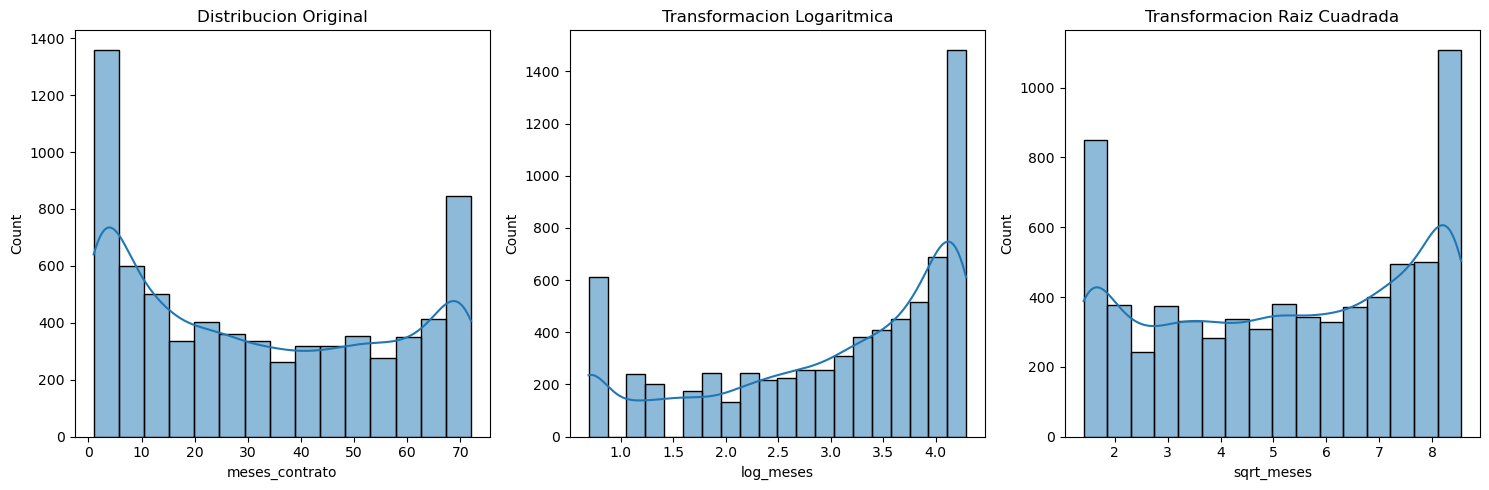

: 

: 

: 

In [ ]:
# visualizacion de la distribucion meses_contrato y las diferentes transformaciones

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribucion Original
BIN_WIDTH = bin_width(df, 'meses_contrato')
sns.histplot(df['meses_contrato'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title("Distribucion Original")

# Transformacion Logaritmica
df['log_meses'] = np.log(df['meses_contrato'] + 1)
BIN_WIDTH = bin_width(df, 'log_meses')
sns.histplot(df['log_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title("Transformacion Logaritmica")

# Transformacion Raíz cuadrada
df['sqrt_meses'] = np.sqrt(df['meses_contrato'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_meses')
sns.histplot(df['sqrt_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title("Transformacion Raiz Cuadrada")

plt.tight_layout()
plt.show()


- Claramente vemos que la distribucion _meses_contrato_ es bimodal.

- Tras aplicar la transformacion logaritmica, se sigue evidenciando una distribucion bimodal.

- Lo mismo se muestra al aplicar la transformacion raiz cuadrada.

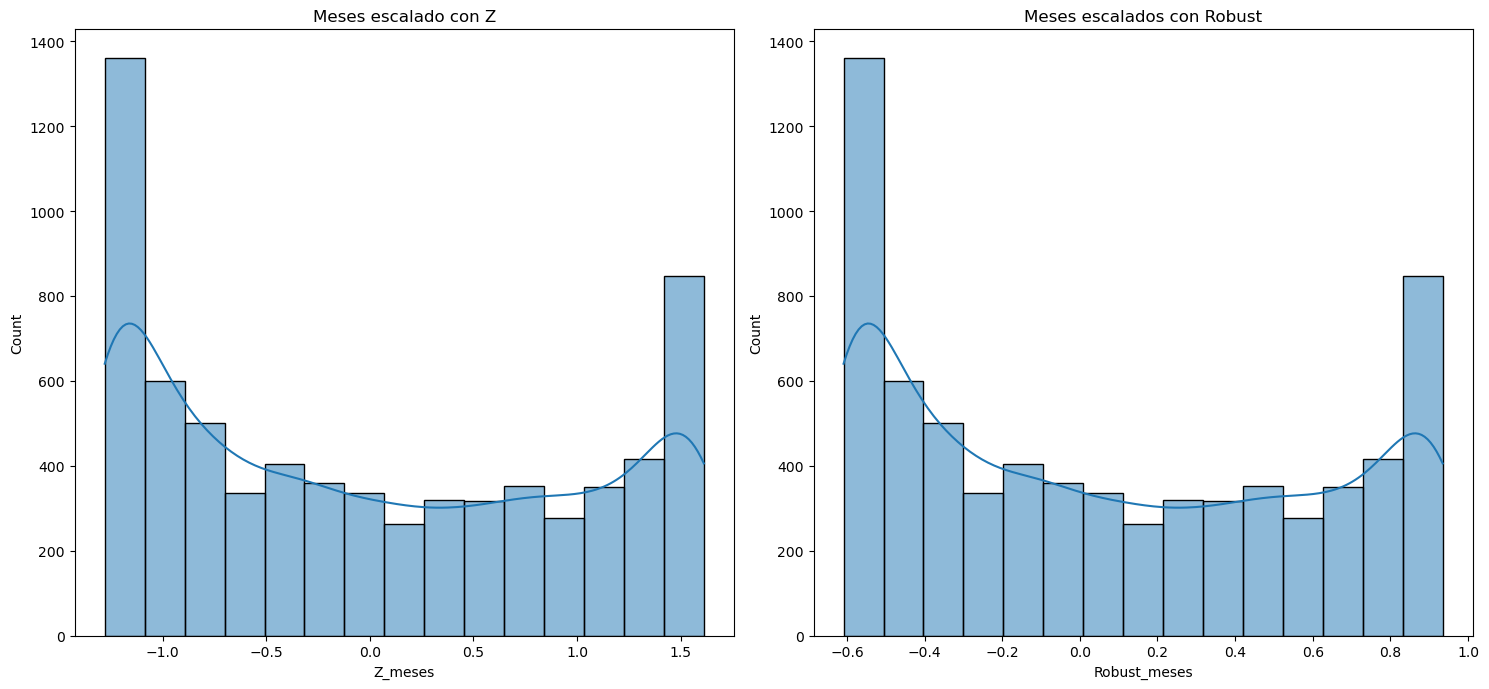

: 

: 

: 

In [ ]:
# visualizacion de meses_contrato escalados de forma estandar y robusta

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# meses_contrato escalado con StandarScaler
df['Z_meses'] = scaler_meses_contrato.fit_transform(df[['meses_contrato']])
BIN_WIDTH = bin_width(df, 'Z_meses')
sns.histplot(df['Z_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Meses escalado con Z')

# meses_contrato escalado con RobustScaler
df['Robust_meses'] = robust_meses_contrato.fit_transform(df[['meses_contrato']])
BIN_WIDTH = bin_width(df, 'Robust_meses')
sns.histplot(df['Robust_meses'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Meses escalados con Robust')

plt.tight_layout()
plt.show()

- Z_meses muestra mas influencia de los valores extremos que de outliers. La forma de la distribucion no cambia

- Robust_meses tiene centrado mejor los valores tipicos por lo que es mas adecuado para outliers. La distribucion esta mas controlada y menos distorcionada.

- Si se usa un modelo sensible a outliers, Robust_meses seria mas apropiado.

__Cuenta Mensual__

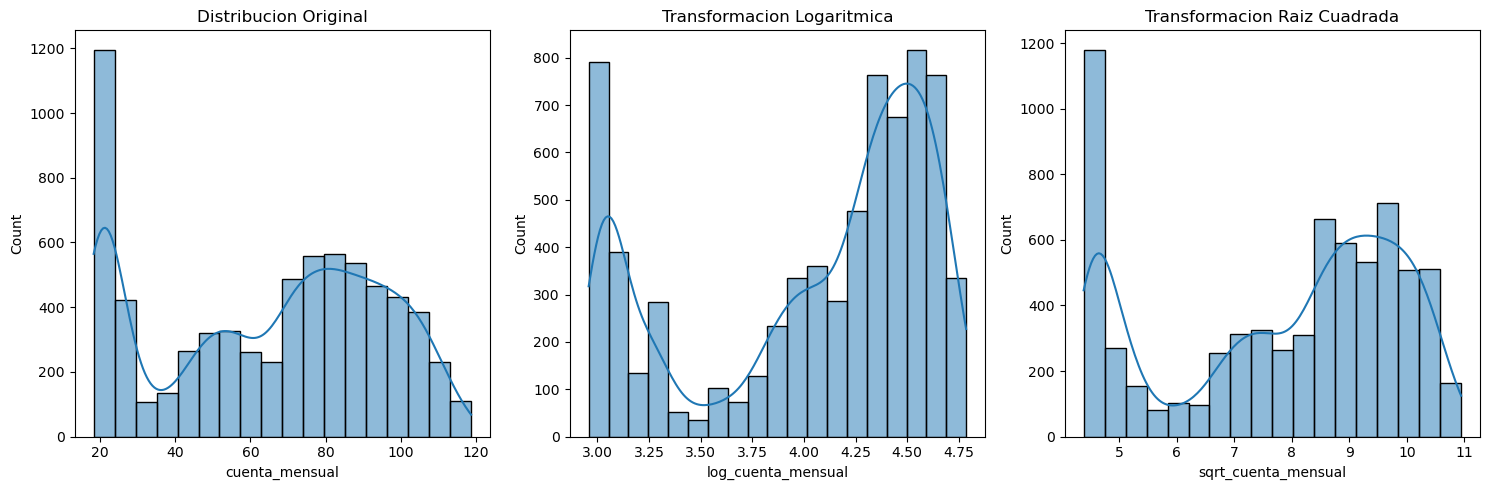

: 

: 

: 

In [ ]:
# visualizacion de la distribucion cuenta_mensual y las diferentes transformaciones

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribucion Original
BIN_WIDTH = bin_width(df, 'cuenta_mensual')
sns.histplot(df['cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title("Distribucion Original")

# Transformacion Logaritmica
df['log_cuenta_mensual'] = np.log(df['cuenta_mensual'] + 1)
BIN_WIDTH = bin_width(df, 'log_cuenta_mensual')
sns.histplot(df['log_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title("Transformacion Logaritmica")

# Transformacion Raíz cuadrada
df['sqrt_cuenta_mensual'] = np.sqrt(df['cuenta_mensual'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_cuenta_mensual')
sns.histplot(df['sqrt_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title("Transformacion Raiz Cuadrada")

plt.tight_layout()
plt.show()


- La distribucion cuenta_mensual es bimodal.

- Al aplicar la transformacion logaritmical y raiz cuadrada sigue mostrando una forma bimodal.

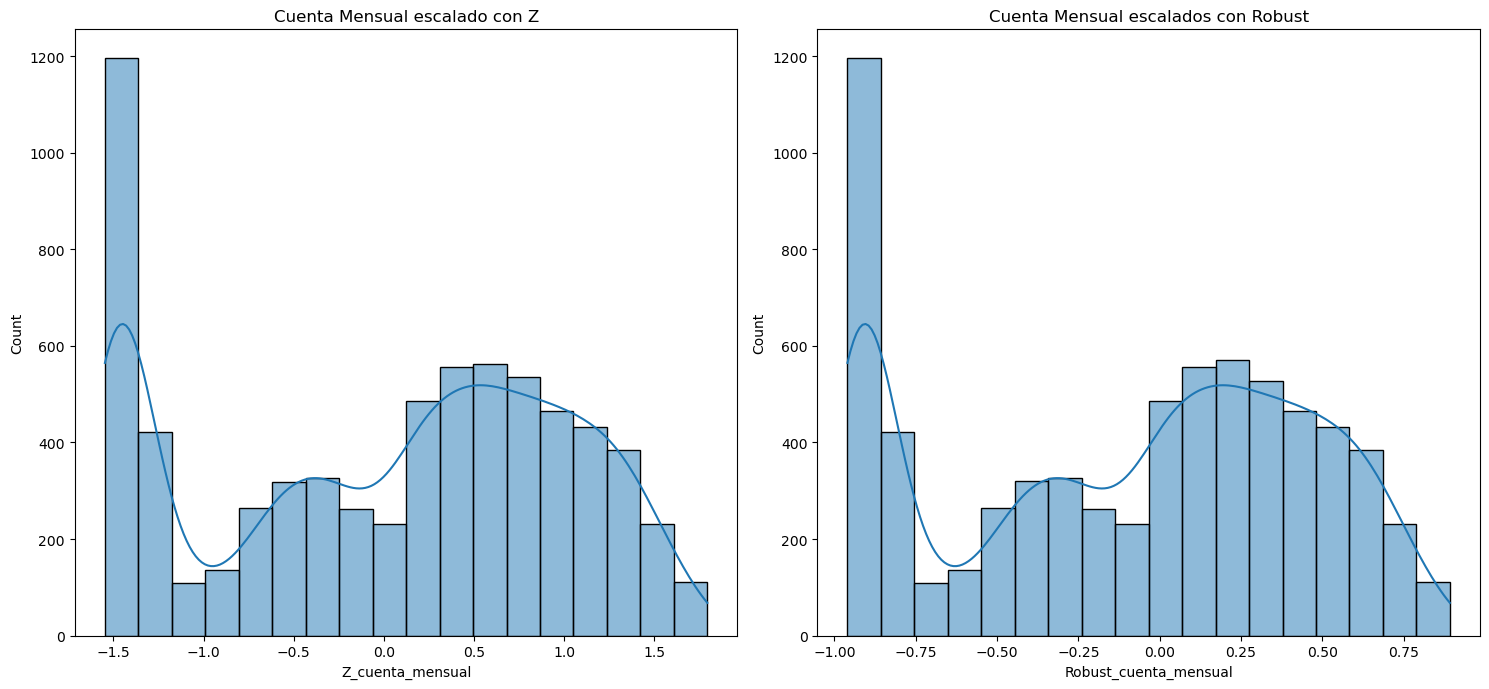

: 

: 

: 

In [ ]:
# visualizacion de cuenta_mensual escalados de forma estandar y robusta

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# meses_contrato escalado con StandarScaler
df['Z_cuenta_mensual'] = scaler_cuenta_mensual.fit_transform(df[['cuenta_mensual']])
BIN_WIDTH = bin_width(df, 'Z_cuenta_mensual')
sns.histplot(df['Z_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Cuenta Mensual escalado con Z')

# meses_contrato escalado con RobustScaler
df['Robust_cuenta_mensual'] = robust_cuenta_mensual.fit_transform(df[['cuenta_mensual']])
BIN_WIDTH = bin_width(df, 'Robust_cuenta_mensual')
sns.histplot(df['Robust_cuenta_mensual'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Cuenta Mensual escalados con Robust')

plt.tight_layout()
plt.show()

- Ambos metodos preservan la distribucion original.

- La distribucion presenta muchos valores bajos concentrados y una cola larga hacia la derecha por lo que es mas adecuado Robust_cuenta_mensual para modelos sensibles a outliers.

__Cuenta Total__

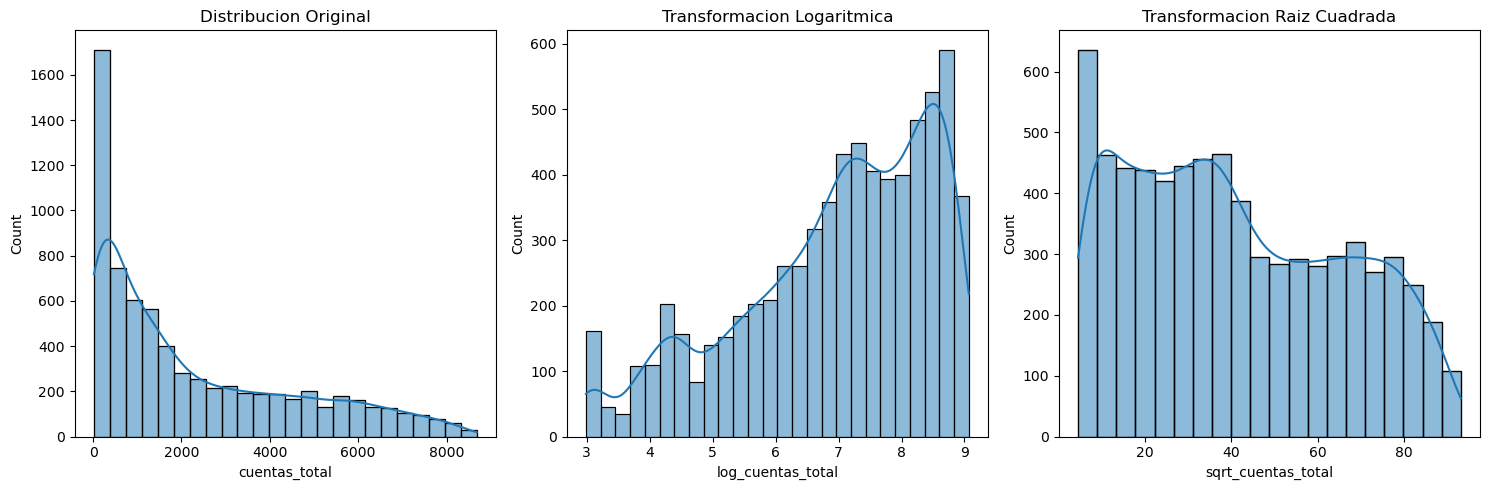

: 

: 

: 

In [ ]:
# visualizacion de la distribucion cuentas_total y las diferentes transformaciones

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribucion Original
BIN_WIDTH = bin_width(df, 'cuentas_total')
sns.histplot(df['cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title("Distribucion Original")

# Transformacion Logaritmica
df['log_cuentas_total'] = np.log(df['cuentas_total'] + 1)
BIN_WIDTH = bin_width(df, 'log_cuentas_total')
sns.histplot(df['log_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title("Transformacion Logaritmica")

# Transformacion Raíz cuadrada
df['sqrt_cuentas_total'] = np.sqrt(df['cuentas_total'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_cuentas_total')
sns.histplot(df['sqrt_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[2])
axes[2].set_title("Transformacion Raiz Cuadrada")

plt.tight_layout()
plt.show()


- La distribucion de cuentas_total presenta asimetria positiva.

- Ninguna de las transformaciones aplicadas logra corregir dicha asimetria.

- Debido a su naturaleza acumulativa, se espera que la mayor concentracion de observaciones se encuentre en valores pequenos teniendo solo valores altos para un grupo seleccionado de clientes, por ejemplo.

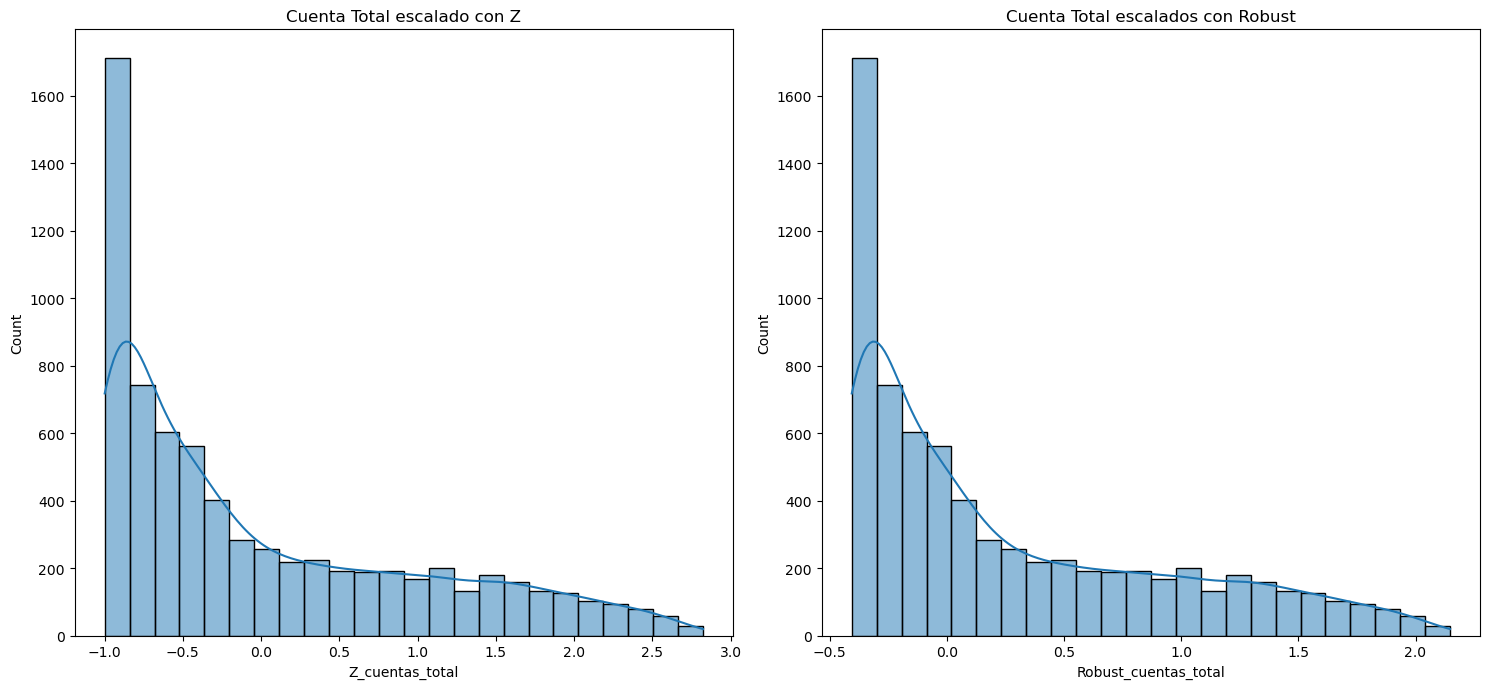

: 

: 

: 

In [ ]:
# visualizacion de cuenta_total escalados de forma estandar y robusta

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# meses_contrato escalado con StandarScaler
df['Z_cuentas_total'] = scaler_cuentas_total.fit_transform(df[['cuentas_total']])
BIN_WIDTH = bin_width(df, 'Z_cuentas_total')
sns.histplot(df['Z_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[0])
axes[0].set_title('Cuenta Total escalado con Z')

# meses_contrato escalado con RobustScaler
df['Robust_cuentas_total'] = robust_cuenta_mensual.fit_transform(df[['cuentas_total']])
BIN_WIDTH = bin_width(df, 'Robust_cuentas_total')
sns.histplot(df['Robust_cuentas_total'], binwidth=BIN_WIDTH, kde=True, ax=axes[1])
axes[1].set_title('Cuenta Total escalados con Robust')

plt.tight_layout()
plt.show()

- Ambos metodos preservan la distribucion original.

Vamos a trabajar con las variables numericas en su estado original y evaluar si los modelos son capaces de interpretarlas correctamente. En caso contrario, utilizaremos las variables escaladas con RobustScaler

In [ ]:
df = df.drop(['log_meses', 'sqrt_meses', 'Z_meses', 'Robust_meses',
              'log_cuenta_mensual', 'sqrt_cuenta_mensual', 'Z_cuenta_mensual', 'Robust_cuenta_mensual',
              'log_cuentas_total', 'sqrt_cuentas_total', 'Z_cuentas_total', 'Robust_cuentas_total'], axis=1)

df.shape

(7032, 29)

: 

: 

: 

## __Analisis de Correlacion__

Analizamos la correlacion entre la variable _cancelacion_ y las demas.

In [ ]:
corr = df.corr()

: 

: 

: 

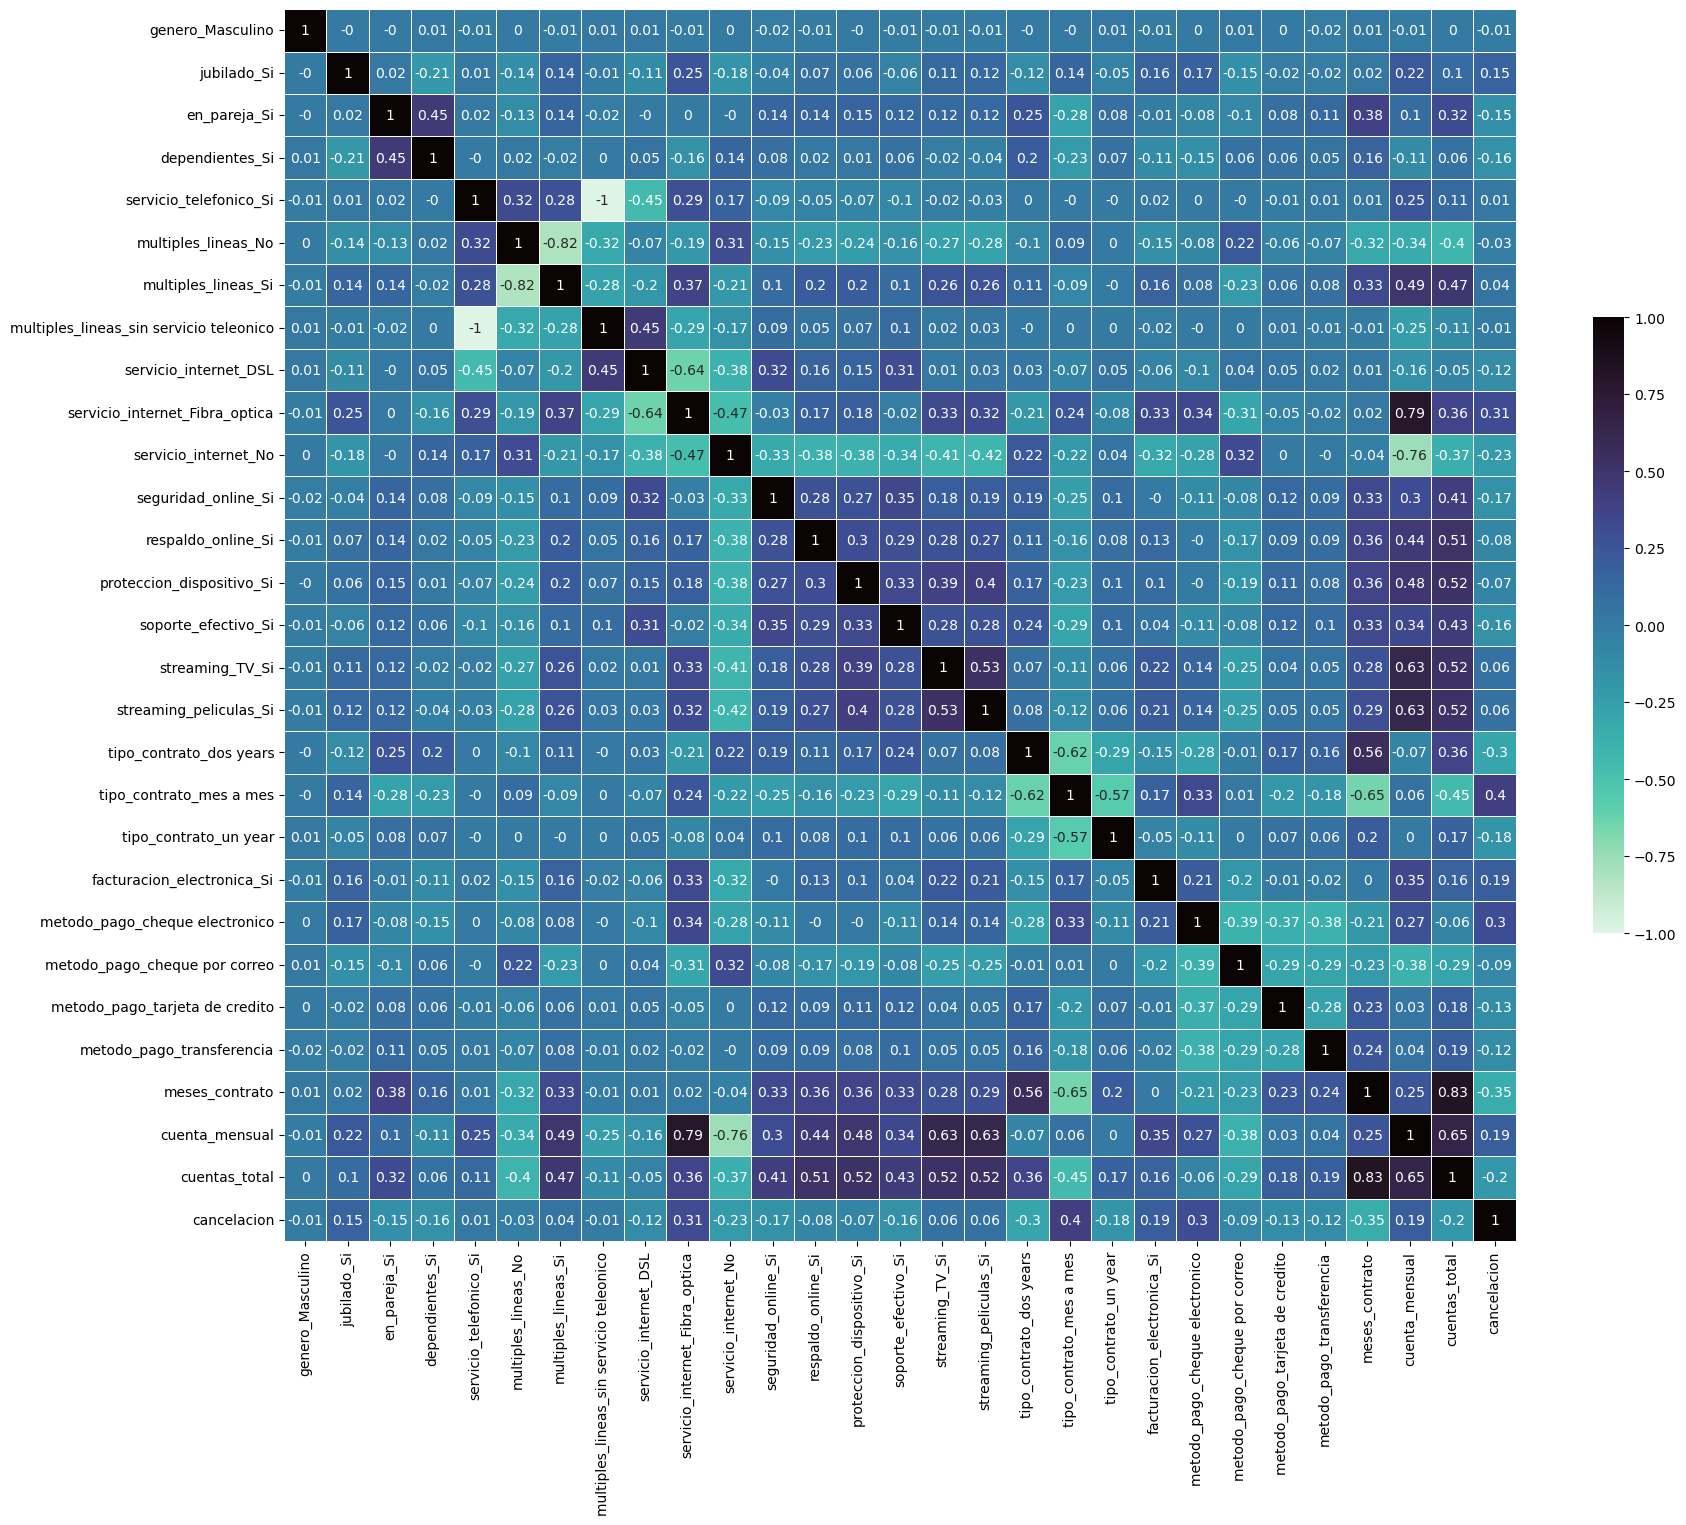

: 

: 

: 

In [ ]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(
    np.round(corr, 2), 
    vmax=1, 
    vmin=-1, 
    center=0,
    square=True,
    linewidths=.5,
    annot=True,
    cbar_kws={'shrink': .5},
    cmap='mako_r'
    )
plt.show()

Debido a la gran cantidad de variables predictoras, vamos a filtrar aquellas cuya correlacion absoluta con _cancelacion_ sea mayor a 0.07

In [ ]:
vars = corr.loc['cancelacion'].abs()[corr.loc['cancelacion'].abs() > 0.07].index
corr_selected = corr[vars].loc[vars]

: 

: 

: 

In [ ]:
# mascar sobre el triangulo superior del heatmap
masc = np.zeros_like(corr_selected, dtype=bool)
masc[np.triu_indices_from(masc)] = True

: 

: 

: 

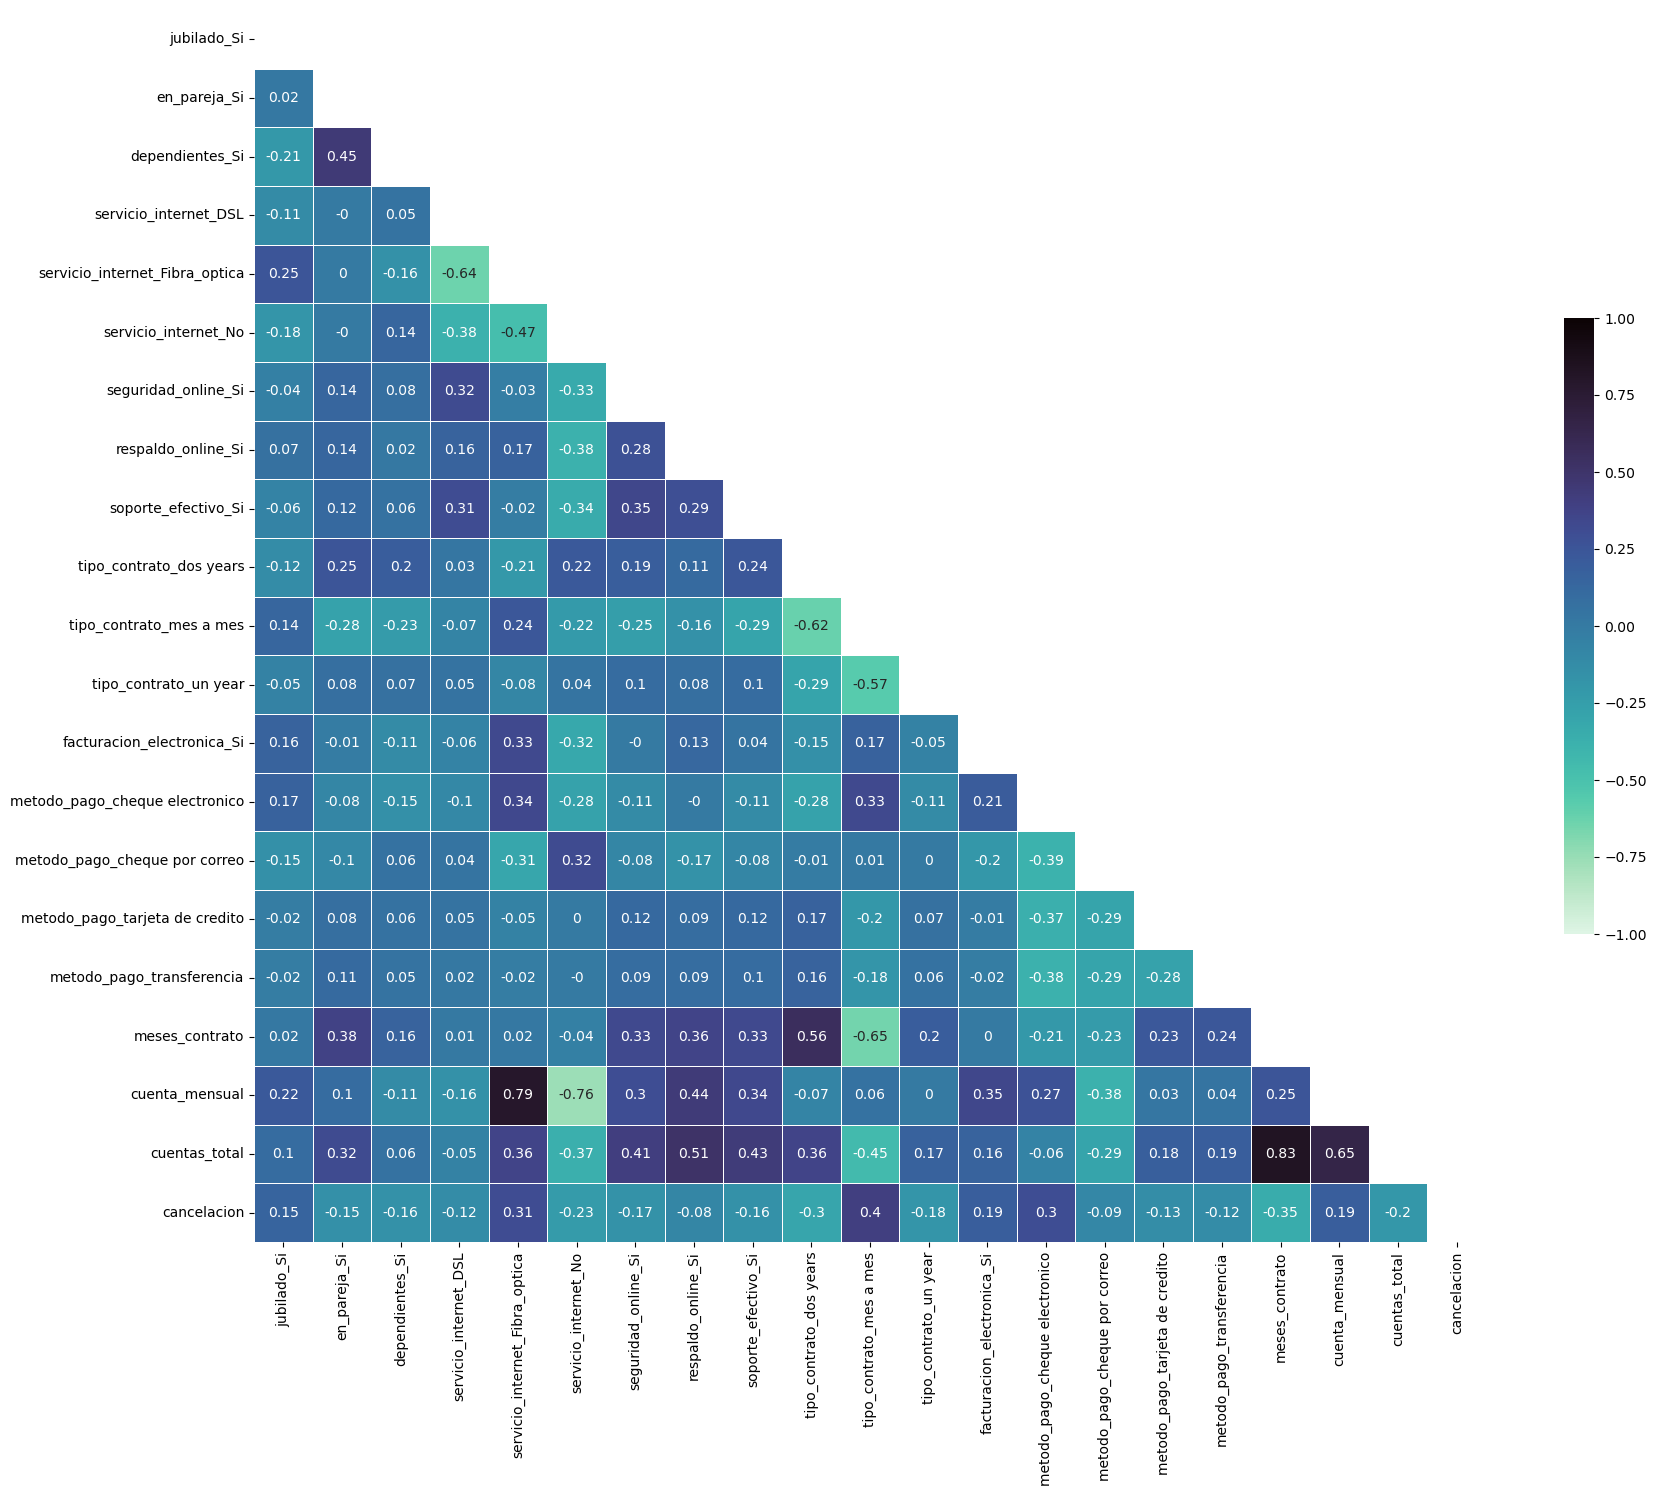

: 

: 

: 

In [ ]:
# visualizacion del heatmap con variables filtradas
fig, ax = plt.subplots(figsize=(20,16))

ax = sns.heatmap(
    np.round(corr_selected, 2), 
    mask=masc, 
    vmax=1, 
    vmin=-1, 
    center=0,
    square=True,
    linewidths=.5,
    annot=True,
    cbar_kws={'shrink': .5},
    cmap='mako_r'
    )

plt.show()

- Resalta una fuerte correlacion entre _cuenta_total_ y _meses_contrato_ (de 0.83). Esto puede deberse a la naturaleza acumulativa de _cuentas_total_, por lo que es posible que esta variable sea explicada con _meses_contrato_ y _cuenta_mensual_.

- Para verificar lo anterior, realizamos un analisis de multicolinealidad a traves del factor __Variance Inflation_Factor__

## __Analisis de Multicolinealidad__

El Variance Inflation Factor realiza una regresion lineal tomando cada variable predictora como variable target y busca explicarlas a traves del resto de variables predictoras. La interpretacion del valor de este factor es la siguiente:

- 1 < VIF < 5, Aceptable.

- 5 < VIF < 10, la variable puede conservarse si se considera necesaria.

- 1 < VIF, Existe colinealidad fuerte entre dicha variable y alguna de las otras variables predictoras. Deben descartarse.

Vamos a utilizar las variables codificadas OneHotEncoder _X_linear_ para asegurar que se descarte la primera categoria de cada feature, evitando que se introduzca multicolinealidad. Tambien vamos a escalar las variables numericas ya que el algoritmo de VIF es sensible a la escala de los datos.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import RobustScaler
from statsmodels.tools.tools import add_constant

: 

: 

In [ ]:
# instanciamos RobustScaler
vif_robust_scaler = RobustScaler()

# copia del df_linear
df_vif = df_linear.copy()

# extraer variable numericas que se van a escalar
x_num = ['meses_contrato', 'cuenta_mensual', 'cuentas_total']
x_vif_num = df_vif[x_num]

# aplicar escalado robusto
x_vif_num = vif_robust_scaler.fit_transform(x_vif_num)

# crear nuevas variables escaladas
df_vif[['robust_meses_contrato', 'robust_cuenta_mensual', 'robust_cuentas_total']] = x_vif_num

# eliminar las variables originales del df_vif
df_vif = df_vif.drop(x_num, axis=1)

# Obtener variables predictoras
X_vif = df_vif.drop('cancelacion', axis=1)

# obtener nombre de las variables predictoras
features = X_vif.columns

# crear un df vacio
df_vif_1 = pd.DataFrame()

# agregar variable con los nombres de las variables predictoras
df_vif_1['Features'] = features

# calcular el VIF para cada variable
df_vif_1['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

# ordenar los resultados y mostrarlos
df_vif_1.sort_values('VIF', ascending=False)


,Features,VIF
22,robust_cuenta_mensual,866.089640
4,servicio_telefonico_Si,578.341895
6,multiples_lineas_sin servicio teleonico,193.449293
7,servicio_internet_Fibra_optica,148.500814
8,servicio_internet_No,104.213701
14,streaming_peliculas_Si,24.156394
13,streaming_TV_Si,24.080019
23,robust_cuentas_total,10.811490
21,robust_meses_contrato,7.584453
5,multiples_lineas_Si,7.289761


: 

: 